# EDA and Data Preprocessing
This notebook will contain all of the EDA and data peprocessing for the project.

In [122]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score, confusion_matrix, auc, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree
pd.set_option('display.max_columns', 100)

In [6]:
# loading data to be used
test_app = pd.read_csv("application_test.csv")
train_app = pd.read_csv('application_train.csv')
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
credit_balance = pd.read_csv('credit_card_balance.csv')
installments_payments = pd.read_csv('installments_payments.csv')
cash_balance = pd.read_csv('POS_CASH_balance.csv')
prev_app = pd.read_csv('previous_application.csv')
display(train_app.head())

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single /

# EDA
This section of the notebook will go through the exploratory data analysis of the project.

In [7]:
print(f'Training Set Size: {train_app.shape}')
print(f'Test Set Size: {test_app.shape}')

Training Set Size: (307511, 122)
Test Set Size: (48744, 121)


0    282686
1     24825
Name: TARGET, dtype: int64


[Text(0, 0, '0 (All other Cases)'), Text(1, 0, '1 (Payment Difficulties)')]

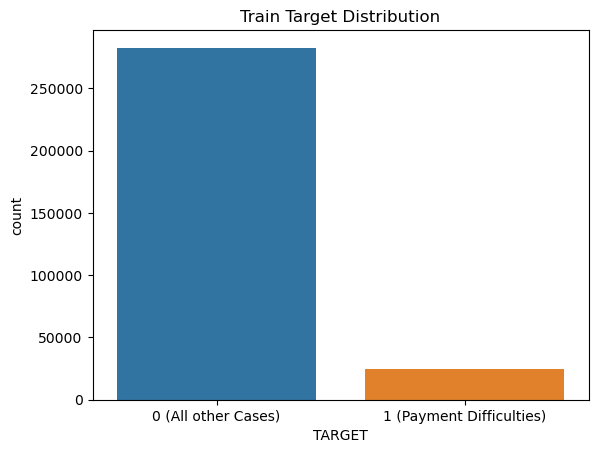

In [9]:
print(train_app.TARGET.value_counts())
plt.title('Train Target Distribution')
plot = sns.countplot(train_app, x = 'TARGET')
plot.set_xticklabels(['0 (All other Cases)', '1 (Payment Difficulties)'])

In [15]:
# checking to see if there are any high correlated variables with the Target
target_correlations = train_app.corr()['TARGET'].sort_values(ascending= False)
top5_corr = pd.DataFrame(target_correlations[1:6]).rename(columns = {'TARGET': 'Correlation'})
bottom5_corr = pd.DataFrame(target_correlations[-5:]).rename(columns = {'TARGET': 'Correlation'})
display(top5_corr)
display(bottom5_corr)

/var/folders/k2/2pvc70391qg50r5yz8h73mzh0000gn/T/ipykernel_55269/2635583608.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  target_correlations = train_app.corr()['TARGET'].sort_values(ascending= False)


,Correlation
DAYS_BIRTH,0.078239
REGION_RATING_CLIENT_W_CITY,0.060893
REGION_RATING_CLIENT,0.058899
DAYS_LAST_PHONE_CHANGE,0.055218
DAYS_ID_PUBLISH,0.051457


,Correlation
FLOORSMAX_AVG,-0.044003
DAYS_EMPLOYED,-0.044932
EXT_SOURCE_1,-0.155317
EXT_SOURCE_2,-0.160472
EXT_SOURCE_3,-0.178919


In [16]:
train_app.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

# Feature Engineering

## 1. Average Credit of Previous Loans

In [17]:
training_ids = train_app['SK_ID_CURR'].unique()
bureau_ids = bureau['SK_ID_CURR'].unique()
matching_ids = np.intersect1d(training_ids, bureau_ids)
print(f"Number of unique IDs in training set: {len(training_ids)}")
print(f'Ids found in the bureau dataset: {len(bureau_ids)}')
print(f'Matching IDs Found: {len(matching_ids)}')

Number of unique IDs in training set: 307511
Ids found in the bureau dataset: 305811
Matching IDs Found: 263491


In [18]:
avg_credit = bureau.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM'].mean().reset_index()
avg_credit

,SK_ID_CURR,AMT_CREDIT_SUM
0,100001,2.076236e+05
1,100002,1.081319e+05
2,100003,2.543501e+05
3,100004,9.451890e+04
4,100005,2.190420e+05
...,...,...
305806,456249,2.841430e+05
305807,456250,1.028820e+06
305808,456253,9.900000e+05
305809,456254,4.500000e+04


In [19]:
def join_to_main_df(main_df, sub_df):
    """
    Join a sub-table back to the main DataFrame used for training

    Parameters:
    main_df: The main training dataset to join a sub-table back to
    sub_df: The sub-table that will be joined to the main table.

    Returns:
    merged_df: The main table merged with the sub-table 
    """
    print(f'Dataset before join: {main_df.shape}')
    merged_df = main_df.merge(sub_df, left_on= 'SK_ID_CURR', right_on = 'SK_ID_CURR', how= 'left')
    print(f'Dataset after join: {merged_df.shape}')
    return merged_df
train_app = join_to_main_df(train_app, avg_credit)
test_app = join_to_main_df(test_app, avg_credit)

Dataset before join: (307511, 122)
Dataset after join: (307511, 123)
Dataset before join: (48744, 121)
Dataset after join: (48744, 122)


## 2. Previous Applications

In [20]:
prev_app_ids = prev_app['SK_ID_CURR'].unique()
matching_prev_app_ids = np.intersect1d(training_ids, prev_app_ids)
print(f'Matching Ids found in the previous application dataset: {len(matching_prev_app_ids)}')

Matching Ids found in the previous application dataset: 291057


In [21]:
status_df = pd.DataFrame(prev_app.groupby(['SK_ID_CURR', 'NAME_CONTRACT_STATUS']).size()).reset_index()
status_df.rename(columns = {0 : 'Count'}, inplace = True )

In [22]:
totals = pd.DataFrame(prev_app.groupby(['SK_ID_CURR']).size()).reset_index().rename(columns = {0 : 'Total'})
status_df_merged = status_df.merge(totals, left_on= 'SK_ID_CURR', right_on = 'SK_ID_CURR', how= 'left')
approvals_table = status_df_merged[status_df_merged['NAME_CONTRACT_STATUS'] == 'Approved']
approvals_table['Approval_Rate'] = approvals_table['Count'] / approvals_table['Total']
approvals_table.rename(columns= {'Count' : 'Num_of_Applications'}, inplace = True)
approvals_table_subset = approvals_table[['SK_ID_CURR', 'Approval_Rate', 'Num_of_Applications' ]]
approvals_table_subset

/var/folders/k2/2pvc70391qg50r5yz8h73mzh0000gn/T/ipykernel_55269/3341366296.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  approvals_table['Approval_Rate'] = approvals_table['Count'] / approvals_table['Total']
/var/folders/k2/2pvc70391qg50r5yz8h73mzh0000gn/T/ipykernel_55269/3341366296.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  approvals_table.rename(columns= {'Count' : 'Num_of_Applications'}, inplace = True)


,SK_ID_CURR,Approval_Rate,Num_of_Applications
0,100001,1.00,1
1,100002,1.00,1
2,100003,1.00,3
3,100004,1.00,1
4,100005,0.50,1
...,...,...,...
610742,456251,1.00,1
610743,456252,1.00,1
610744,456253,1.00,2
610745,456254,1.00,2


In [23]:
train_app = join_to_main_df(train_app, approvals_table_subset)
test_app = join_to_main_df(test_app, approvals_table_subset)

Dataset before join: (307511, 123)
Dataset after join: (307511, 125)
Dataset before join: (48744, 122)
Dataset after join: (48744, 124)


## Average Difference of Installment Payments
The next feature that will be added is the differnce of the monthly payments. This will look at the difference between the instalment and the amount paid for each client.

In [24]:
installments_payments = installments_payments.fillna(0)
avg_diff = installments_payments.groupby(['SK_ID_CURR']).apply(lambda x: (x['AMT_INSTALMENT'] - x['AMT_PAYMENT']).mean()).reset_index(name = 'avg_install_diff')
train_app = join_to_main_df(train_app, avg_diff)
test_app = join_to_main_df(test_app, avg_diff)

Dataset before join: (307511, 125)
Dataset after join: (307511, 126)
Dataset before join: (48744, 124)
Dataset after join: (48744, 125)


## Max Credit by Client
The final feature that will be added is the max credit that a client has.

In [25]:
## Max Credit by Client
max_credit = credit_balance.groupby(['SK_ID_CURR']).apply(lambda x: (x['AMT_BALANCE']).max()).reset_index(name = 'max_credit')
train_app = join_to_main_df(train_app, max_credit)
test_app = join_to_main_df(test_app, max_credit)

Dataset before join: (307511, 126)
Dataset after join: (307511, 127)
Dataset before join: (48744, 125)
Dataset after join: (48744, 126)


# Data Preparation

## Missing Values 

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Te

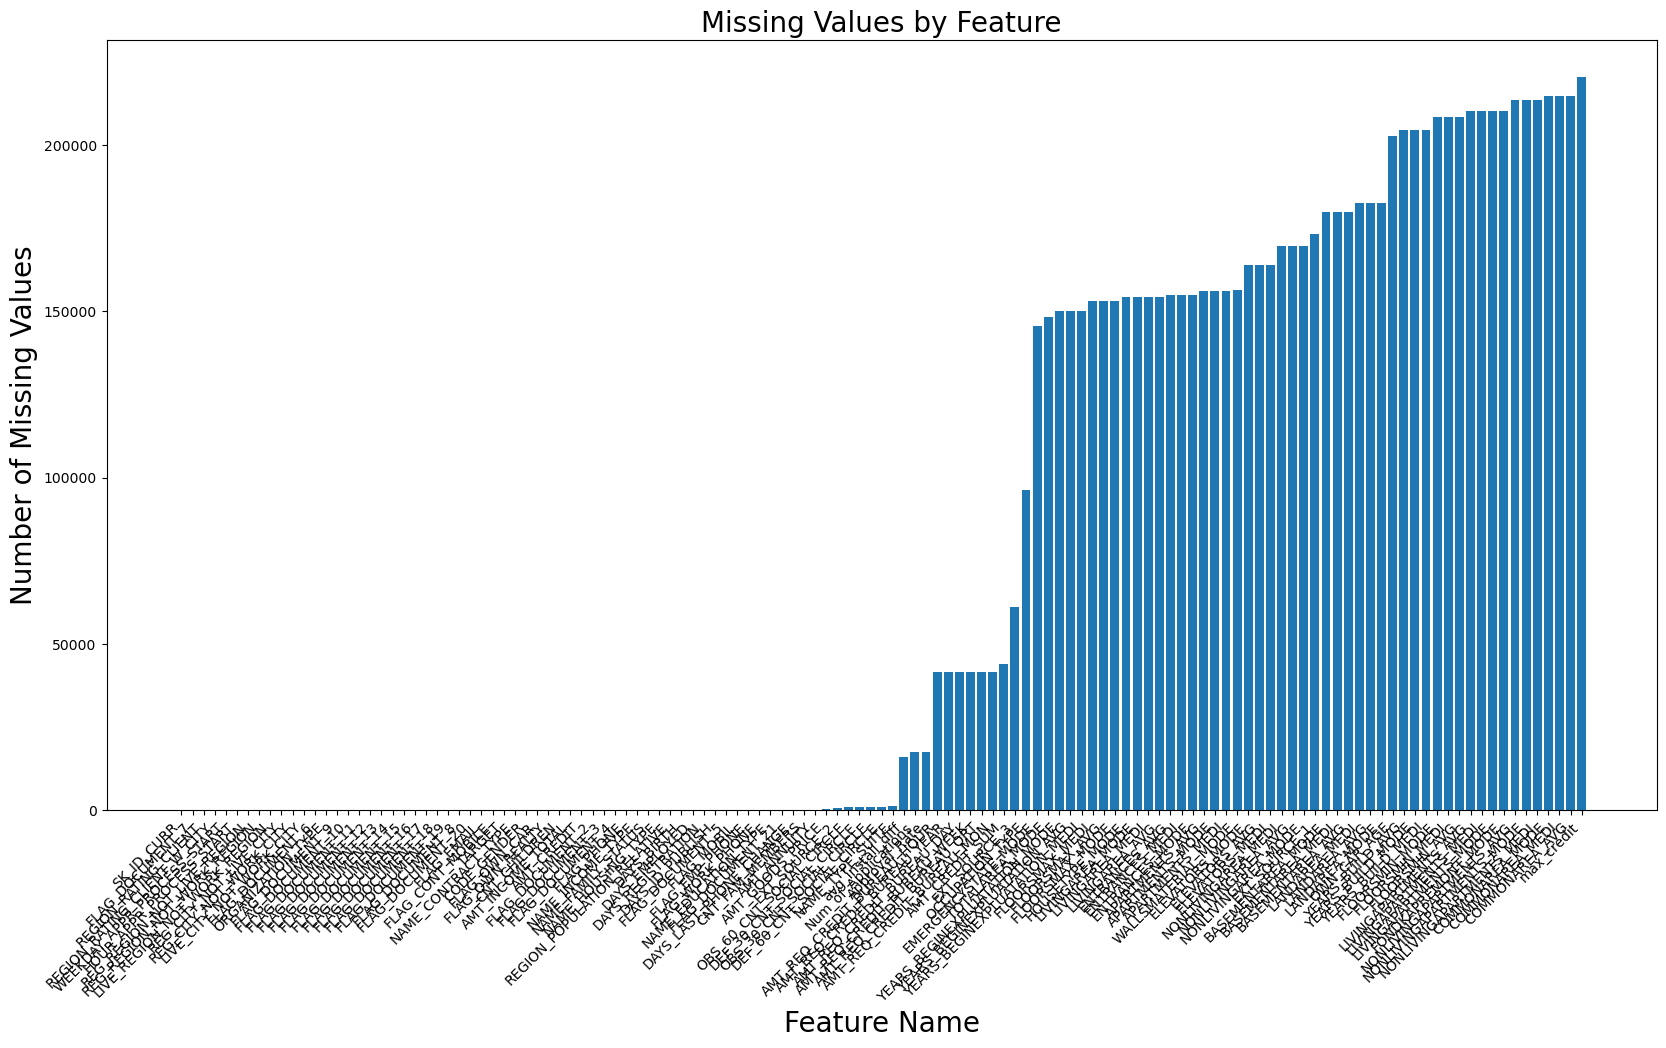

In [26]:
missing_vals = train_app.isnull().sum().sort_values()
plt.figure(figsize=(20,10))
plt.title('Missing Values by Feature', size = 20)
plt.xlabel('Feature Name', size = 20)
plt.ylabel('Number of Missing Values', size = 20 )
plt.bar(missing_vals.keys(), missing_vals.values)
plt.xticks(rotation=45, ha='right', va='top')

In [27]:
threshold = 0.70 # percent of existing data 
missing_vals_threshold = len(train_app) * threshold # number of recrods needed to have that value
max_missing_vals = int(len(train_app) - missing_vals_threshold) # max # of missing values to have 60% of the data 
missing_vals = dict(train_app.isnull().sum().sort_values(ascending = False))
missing_vals_cols = {k: v for (k,v) in missing_vals.items() if v > max_missing_vals}
missing_vals_df = pd.DataFrame({"Column Name" : list(missing_vals_cols.keys()), 'Missing Values' : list(missing_vals_cols.values())})

In [28]:
cols_to_drop = list(missing_vals_cols.keys())
train_df_subset =train_app.drop(columns = cols_to_drop)
test_df_subset = test_app.drop(columns =cols_to_drop )
train_df_subset

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_SUM,Approval_Rate,Num_of_Applications,avg_install_diff
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,0.139376,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,108131.945625,1.000000,1.0,0.000000
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,NaN,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,254350.125000,1.000000,3.0,0.000000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0.555912,0.729567,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,94518.900000,1.000000,1.0,0.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,1,1,0,1,0,0,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,0.650442,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.555556,5.0,0.000000
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,1,1,0,1,0,0,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0.322738,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,146250.000000,1.000000,6.0,452.384318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,0.032561,-9327,-236,-8456.0,-1982,1,1,0,1,0,0,1.0,1,1,THURSDAY,15,0,0,0,0,0,0,Services,0.681632,NaN,0.0,0.0,0.0,0.0,-273.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.0,0.000000
307507,456252,0,Cash loans,F,N,Y,0,7

In [29]:
def impute_missing_values(df):
    """
    Impute missing values in a DataFrame column with the most frequent value if the column is of type 'object'
    and with the mean if the column is numeric.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the column to be imputed.
    column (str): The name of the column to impute.

    Returns:
    pd.DataFrame: The DataFrame with the imputed column.
    """
    for column in list(df.columns):
        if df[column].dtype == 'object':
            # Use most frequent value for categorical data
            imputer = SimpleImputer(strategy='most_frequent')
        else:
            # Use mean for numeric data
            imputer = SimpleImputer(strategy='mean')
        
        # Impute missing values
        df[column] = imputer.fit_transform(df[[column]])
    
    return df

In [30]:
train_df_imputed = impute_missing_values(train_df_subset)
test_df_imputed = impute_missing_values(test_df_subset)

## Encoding

In [31]:
train_df_dtypes = train_df_imputed.dtypes
test_df_dtypes = test_df_imputed.dtypes
def label_encoder(col):
    """
    Transforms a column from categorical to numeric
    based on the number of classes.

    Parameters
    ----------
    col : series
      The pandas series to be transformed

   Returns
   ----------
   series
      The transformed series
    """
    encoder = LabelEncoder()
    encoder.fit(col)
    return encoder.transform(col)
def encode_cols(dtypes_df, df):
   """
    Transforms all categorical columns of a 
    dataframe to numeric.

    Parameters
    ----------
    dtypes_df : DataFrame
      DataFrame containing the column names and 
      data types for all columns in the DataFrame
   
   df: DataFrame
      The original DataFrame to be transformed

   Returns
   ----------
   df
      The transformed DataFrame
    """
   for column_name, dtype in zip(list(dtypes_df.keys()), list(dtypes_df.values)):
      if dtype == 'object':
         df[column_name] = label_encoder(df[column_name])
   return df
train_df_subset_encoded = encode_cols(train_df_dtypes, train_df_imputed)
test_df_subset_encoded = encode_cols(test_df_dtypes, test_df_imputed)

In [32]:
train_df_subset_encoded

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_SUM,Approval_Rate,Num_of_Applications,avg_install_diff
0,100002.0,1.0,0,1,0,1,0.0,202500.0,406597.5,24700.5,351000.0,6,7,4,3,1,0.018801,-9461.0,-637.0,-3648.0,-2120.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,2.0,6,10.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0.262949,0.139376,2.0,2.0,2.0,2.0,-1134.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.000000,0.000000,0.000000,1.000000,108131.945625,1.000000,1.0,0.000000
1,100003.0,0.0,0,0,0,0,0.0,270000.0,1293502.5,35698.5,1129500.0,1,4,1,1,1,0.003541,-16765.0,-1188.0,-1186.0,-291.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,1.0,1.0,1,11.0,0.0,0.0,0.0,0.0,0.0,0.0,39,0.622246,0.510853,1.0,0.0,1.0,0.0,-828.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,254350.125000,1.000000,3.0,0.000000
2,100004.0,0.0,1,1,1,1,0.0,67500.0,135000.0,6750.0,135000.0,6,7,4,3,1,0.010032,-19046.0,-225.0,-4260.0,-2531.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,1,9.0,0.0,0.0,0.0,0.0,0.0,0.0,11,0.555912,0.729567,0.0,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,94518.900000,1.000000,1.0,0.000000
3,100006.0,0.0,0,0,0,1,0.0,135000.0,312682.5,29686.5,297000.0,6,7,4,0,1,0.008019,-19005.0,-3039.0,-9833.0,-2437.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,6,17.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0.650442,0.510853,2.0,0.0,2.0,0.0,-617.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974,378080.200789,0.555556,5.0,0.000000
4,100007.0,0.0,0,1,0,1,0.0,121500.0,513000.0,21865.5,513000.0,6,7,4,3,1,0.028663,-19932.0,-3038.0,-4311.0,-3458.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,4,11.0,0.0,0.0,0.0,0.0,1.0,1.0,37,0.322738,0.510853,0.0,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,146250.000000,1.000000,6.0,452.384318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251.0,0.0,0,1,0,0,0.0,157500.0,254700.0,27558.0,225000.0,6,7,4,2,5,0.032561,-9327.0,-236.0,-8456.0,-1982.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,4,15.0,0.0,0.0,0.0,0.0,0.0,0.0,43,0.681632,0.510853,0.0,0.0,0.0,0.0,-273.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006402,0.007,0.034362,0.26739

In [33]:
smote = SMOTE(random_state=12, sampling_strategy= 0.35)
x_data = train_df_subset_encoded.drop(columns= ['TARGET'])
y_data = train_df_subset_encoded['TARGET']
X_resampled, y_resampled = smote.fit_resample(x_data, y_data)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled, test_size=0.20, random_state=42)

# Model Building and Selection
## K Fold Cross Validation

In [35]:
KFolds = KFold(n_splits=3, shuffle=True, random_state=42)
log_reg = LogisticRegression(penalty='l2', C = 0.80)
scores = cross_val_score(log_reg, X_train, y_train, cv=KFolds, scoring='roc_auc')

/Users/zgalante/miniforge3/envs/w207_final/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/zgalante/miniforge3/envs/w207_final/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

# Feature Selection
- Due to the high number of features, we'll be using a Logistic Regression model with L1 regularization to eliminate certain features when their coefficients are pushed to 0, which is done to two features.

In [48]:
l1_log_reg = LogisticRegression(penalty= 'l1', solver = 'liblinear')
l1_log_reg.fit(X_train, y_train)
l1_predictions = l1_log_reg.predict_proba(X_test)
importances = np.abs(l1_log_reg.coef_)[0]
feature_importances = dict(zip(list(X_train.columns) ,importances))
sorted_dict_desc = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))
sorted_dict_desc

{'FLAG_EMP_PHONE': 3.682630075295077,
 'EXT_SOURCE_3': 2.8392893772871988,
 'FLAG_MOBIL': 2.3338705601492085,
 'EXT_SOURCE_2': 2.3228196173324367,
 'FLAG_DOCUMENT_4': 2.026049602845383,
 'FLAG_DOCUMENT_2': 1.9328302846301761,
 'NAME_CONTRACT_TYPE': 1.7749706095280768,
 'CNT_CHILDREN': 1.5415018013326844,
 'CNT_FAM_MEMBERS': 1.5001923512554305,
 'FLAG_DOCUMENT_11': 1.465226277675002,
 'FLAG_DOCUMENT_9': 1.2651028128844515,
 'FLAG_DOCUMENT_21': 1.1341900525809088,
 'FLAG_DOCUMENT_6': 1.106470908187044,
 'FLAG_DOCUMENT_18': 1.0865490767567147,
 'FLAG_DOCUMENT_14': 1.059566253573327,
 'FLAG_DOCUMENT_3': 1.0460328995073636,
 'REGION_POPULATION_RELATIVE': 0.9776229158023226,
 'FLAG_DOCUMENT_5': 0.9574201532047648,
 'FLAG_DOCUMENT_17': 0.9501985555466805,
 'FLAG_OWN_CAR': 0.9479454082273325,
 'FLAG_DOCUMENT_16': 0.9440446572503555,
 'FLAG_DOCUMENT_8': 0.8327285086800443,
 'FLAG_OWN_REALTY': 0.7182500448964245,
 'FLAG_DOCUMENT_13': 0.7099417704414211,
 'NAME_FAMILY_STATUS': 0.7098734953441355,

## Logistic Regression

In [139]:
model_comparisson = pd.DataFrame(columns = ['Model Name', 'Accuracy Score', 'F1 Score', 'AUC', 'Training Time (Seconds)'])

In [140]:
log_reg = LogisticRegression(penalty='l2', C = 0.80)
start_time = time.time()
log_reg.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time
log_reg_accuracy = log_reg.score(X_test,y_test)
log_reg_prediction_probs = log_reg.predict_proba(X_test)
log_reg_predictions = log_reg.predict(X_test)
log_reg_auc_score = roc_auc_score(y_test, log_reg_prediction_probs[:,1])
log_reg_f1 = f1_score(y_test, log_reg_predictions)
log_reg_results = ['Logistic Regression', round(log_reg_accuracy,2), round(log_reg_f1,2),  round(log_reg_auc_score,2),  round(training_time,2)]
model_comparisson.loc[len(model_comparisson)] = log_reg_results
model_comparisson

/Users/zgalante/miniforge3/envs/w207_final/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model Name,Accuracy Score,F1 Score,AUC,Training Time (Seconds)
0,Logistic Regression,0.74,0.0,0.63,3.47


# Decision Tree

In [143]:
decision_tree = tree.DecisionTreeClassifier()
start_time = time.time()
decision_tree.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time
decision_tree_predictions = decision_tree.predict(X_test)
decision_tree_accuracy = decision_tree.score(X_test, y_test)
decision_tree_probabilities = decision_tree.predict_proba(X_test)
decision_tree_f1 = f1_score(y_test, decision_tree_predictions)
decision_tree_auc_score = roc_auc_score(y_test, decision_tree_probabilities[:,1] )
decision_tree_results = ['Decision Tree', round(decision_tree_accuracy,2), round(decision_tree_f1,2),  round(decision_tree_auc_score,2),  round(training_time,2)]
model_comparisson.loc[len(model_comparisson)] = decision_tree_results
model_comparisson


,Model Name,Accuracy Score,F1 Score,AUC,Training Time (Seconds)
0,Logistic Regression,0.74,0.00,0.63,3.47
1,Decision Tree,0.86,0.74,0.83,7.70


# Random Forest

In [145]:
random_forest = RandomForestClassifier(n_estimators= 350, criterion= 'log_loss')
start_time = time.time()
random_forest.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time
rf_accuracy_score = random_forest.score(X_test, y_test)
rf_prediction_probs = random_forest.predict_proba(X_test)
rf_predictions = random_forest.predict(X_test)
rf_auc_score = roc_auc_score(y_test, rf_prediction_probs[:,1])
rf_f1_score = f1_score(y_test, rf_predictions)
rf_results = ['Random Forest', round(rf_accuracy_score,2), round(rf_f1_score,2),  round(rf_auc_score,2),  round(training_time,2)]
model_comparisson.loc[len(model_comparisson)] = rf_results
model_comparisson

,Model Name,Accuracy Score,F1 Score,AUC,Training Time (Seconds)
0,Logistic Regression,0.74,0.00,0.63,3.47
1,Decision Tree,0.86,0.74,0.83,7.70
2,Random Forest,0.93,0.85,0.95,230.37


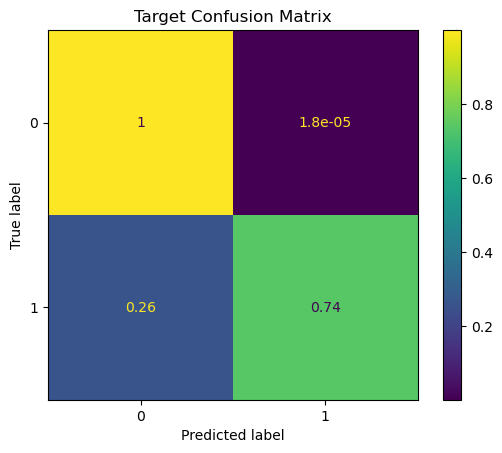

In [118]:
# confusion matrix
cm = confusion_matrix(y_test, rf_predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
disp.plot()
plt.title('Target Confusion Matrix')
plt.show()

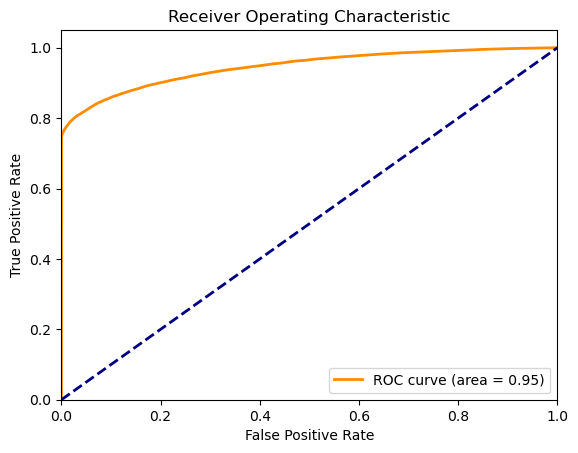

In [106]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, rf_prediction_probs[:,1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve and AUC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

,Column,Importance
0,EXT_SOURCE_2,0.054111
1,EXT_SOURCE_3,0.046237
2,REG_CITY_NOT_WORK_CITY,0.045228
3,Approval_Rate,0.039672
4,FLAG_PHONE,0.036101
5,REGION_RATING_CLIENT,0.035130
6,OBS_30_CNT_SOCIAL_CIRCLE,0.034478
7,REGION_RATING_CLIENT_W_CITY,0.032495
8,OBS_60_CNT_SOCIAL_CIRCLE,0.031206
9,LIVE_CITY_NOT_WORK_CITY,0.030093


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

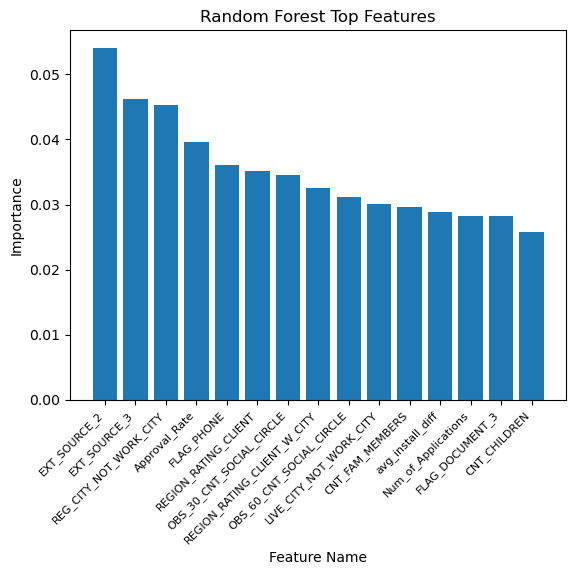

In [94]:
# feature importance for best model 
importances = random_forest.feature_importances_
feature_importances = dict(zip(list(X_train.columns) ,importances))
sorted_dict_desc = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))
top_features = pd.DataFrame.from_dict(sorted_dict_desc, orient= 'index').reset_index().rename(columns = {0 : 'Importance', 'index' : 'Column'}).head(15)
display(top_features)
#plt.figure(figsize=(8,5))
plt.title('Random Forest Top Features', size = 12)
plt.xlabel('Feature Name', size = 10)
plt.ylabel('Importance', size = 10)
plt.bar(top_features['Column'], top_features['Importance'])
plt.xticks(rotation=45, ha='right', va='top', size = 8)

In [187]:
# predicting on the test set 
predictions = random_forest.predict_proba(test_df_subset_encoded)
predictions = predictions[:,1]
predictions_df = pd.DataFrame({'SK_ID_CURR' : test_df_subset_encoded['SK_ID_CURR'], 'TARGET' :predictions})
predictions_df['SK_ID_CURR'] = predictions_df['SK_ID_CURR'].astype(int)
predictions_df.to_csv('predictions.csv', index= False)

## Neural Network 

In [152]:
model = Sequential()
model.add(Dense(units = 500, input_dim=75, activation='relu'))
model.add(Dense(units = 700, input_dim=500, activation='relu'))
model.add(Dense(units = 1, input_dim=700, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
# Train the model
start_time = time.time()
model.fit(X_train, y_train, epochs=15, batch_size=50, verbose=1)
end_time = time.time()
training_time = end_time - start_time
# Evaluate the model

Epoch 1/15
6106/6106 [==============================] - 13s 2ms/step - loss: 315.8513 - accuracy: 0.6345 - auc: 0.5233
Epoch 2/15
6106/6106 [==============================] - 11s 2ms/step - loss: 9.4748 - accuracy: 0.7002 - auc: 0.5206
Epoch 3/15
6106/6106 [==============================] - 12s 2ms/step - loss: 52.7357 - accuracy: 0.7404 - auc: 0.4995
Epoch 4/15
6106/6106 [==============================] - 13s 2ms/step - loss: 0.5786 - accuracy: 0.7404 - auc: 0.4981
Epoch 5/15
6106/6106 [==============================] - 13s 2ms/step - loss: 0.5728 - accuracy: 0.7404 - auc: 0.4988
Epoch 6/15
6106/6106 [==============================] - 12s 2ms/step - loss: 0.5729 - accuracy: 0.7404 - auc: 0.4994
Epoch 7/15
6106/6106 [==============================] - 11s 2ms/step - loss: 0.5729 - accuracy: 0.7404 - auc: 0.4993
Epoch 8/15
6106/6106 [==============================] - 12s 2ms/step - loss: 0.5729 - accuracy: 0.7404 - auc: 0.4996
Epoch 9/15
6106/6106 [==============================] - 13s 2

In [161]:
loss, nn_accuracy, nn_auc_score = model.evaluate(X_test, y_test, verbose=0)
nn_results = ['Neural Network', round(nn_accuracy,2), round(0.53,2),  round(nn_auc_score,2),  round(training_time,2)]
model_comparisson.loc[len(model_comparisson)] = nn_results

In [162]:
model_comparisson

,Model Name,Accuracy Score,F1 Score,AUC,Training Time (Seconds)
0,Logistic Regression,0.74,0.00,0.63,3.47
1,Decision Tree,0.86,0.74,0.83,7.70
2,Random Forest,0.93,0.85,0.95,230.37
4,Neural Network,0.74,0.53,0.50,181.59


# Failed Attempts

In [ ]:
# SVM Model that took too long to train
svm_model = SVC(kernel='linear', probability= True )
svm_model.fit(X_train, y_train)
# Predict the labels for the test set
y_pred = svm_model.predict(X_test)

In [ ]:
# failed grid search attempt -- took too long 
from sklearn.ensemble import RandomForestClassifier
rf_parameter_grid = {'n_estimators' : [150, 200, 300], 'criterion' : ['gini', 'log_loss'], 'max_depth' : [10]}
random_forest = RandomForestClassifier()
rf_grid_search = GridSearchCV(random_forest, rf_parameter_grid, scoring = 'roc_auc')
rf_grid_search.fit(X_train, y_train)